## Moving the code to be compatible with tensorflow 2.0
- Eager execution is enabled by default in TF2.0 so you dont have to explicitly call tf.enable_eager_excecution()

- Change tf.train.get_or_create_global_step() to tf.compat.v1.train.get_or_create_global_step(). Do the same with tf.train.MomentumOptimizer

In [0]:
!pip install --upgrade tensorflow tensorflow-gpu

In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
# import tensorflow.contrib.eager as tfe

In [0]:
# tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)
train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)



## Convert Numpy Images to TFRecords

In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy()
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def convert_np_to_tf_example(image, label):
    feature_dict = {
        'image': _bytes_feature(image.tostring()),
        'label': _int64_feature(label),
    }

    features = tf.train.Features(feature=feature_dict)
    tf_example = tf.train.Example(features=features)
    protocol_message = tf_example.SerializeToString()

    return protocol_message

def convert_proto_message_to_np(protocol_message):
    feature_dict = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_out = tf.io.parse_single_example(serialized=protocol_message,
                                            features=feature_dict)
    
    image = tf.io.decode_raw(parsed_out['image'], out_type=tf.float32)
    label = parsed_out['label']

    return (image,label)
    
def reshape_img(X, img_shape):
    img = X[0].numpy()
    label = X[1]
    img = img.reshape(img_shape)
    img_tensor = tf.convert_to_tensor(img)

    return (img_tensor, label)
    

def convert_np_to_tfrecords(images, labels, 
                            batch_size=128,filename=None):

    # Converts a numpy array into TFReocrds
    

    channels = images.shape[-1]
    width = images.shape[-2]
    height = images.shape[-3]

    img_shape = (height, width, channels)
    if filename == None:
        filename = 'dataset.tfrecords'
    with tf.io.TFRecordWriter(filename) as writer:
        for img,label in zip(images,labels):
            protocol_message = convert_np_to_tf_example(img,label)

            writer.write(protocol_message)
        
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(convert_proto_message_to_np)
    dataset = dataset.map(lambda x, y: (tf.reshape(x,img_shape), y))
    # dataset = dataset.batch(batch_size)
    return dataset

In [0]:
dataset = convert_np_to_tfrecords(x_train, y_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.49139968 0.48215841 0.44653091]
(40, 40, 3)


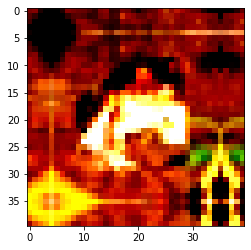

In [64]:
import matplotlib.pyplot as plt
print(train_mean/255)
for d in dataset.take(1):
    plt.imshow(d[0]+train_mean/255)
    print(d[0].shape)

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.compat.v1.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.compat.v1.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.image.random_crop(x, [32, 32, 3])), y)

In [74]:
t = time.time()
"""
    Here is my part
"""
original_train_set = convert_np_to_tfrecords(x_train, y_train, batch_size=1,filename='train_set.tfrecords')
test_set = convert_np_to_tfrecords(x_test, y_test, batch_size=BATCH_SIZE, filename='test_set.tfrecords').batch(BATCH_SIZE)
# test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  
  train_set = original_train_set.map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(2)
#   train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)


  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x,y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)

epoch: 1 lr: 0.08 train loss: 2.0332612292480468 train acc: 0.2485 val loss: 1.5564380249023437 val acc: 0.4169 time: 38.77595329284668


epoch: 2 lr: 0.16 train loss: 1.3626590240478516 train acc: 0.49542 val loss: 1.2882401580810547 val acc: 0.5353 time: 70.2677309513092


epoch: 3 lr: 0.24 train loss: 0.9753562457275391 train acc: 0.64748 val loss: 1.0522348052978516 val acc: 0.6421 time: 101.93334579467773


epoch: 4 lr: 0.32 train loss: 0.7485509448242188 train acc: 0.73504 val loss: 0.7577684234619141 val acc: 0.7346 time: 133.53625297546387


epoch: 5 lr: 0.4 train loss: 0.5955536151123046 train acc: 0.79258 val loss: 0.6402620361328125 val acc: 0.7733 time: 165.276428937912


epoch: 6 lr: 0.37894736842105264 train loss: 0.4987642141723633 train acc: 0.82736 val loss: 0.6745855285644531 val acc: 0.774 time: 197.07465052604675


epoch: 7 lr: 0.35789473684210527 train loss: 0.4380234861755371 train acc: 0.84604 val loss: 0.49972619018554687 val acc: 0.8311 time: 228.74608969688416


epoch: 8 lr: 0.33684210526315794 train loss: 0.3819366256713867 train acc: 0.86932 val loss: 0.5097984771728515 val acc: 0.8291 time: 260.50727248191833


epoch: 9 lr: 0.31578947368421056 train loss: 0.33821502990722657 train acc: 0.8833 val loss: 0.45339520263671873 val acc: 0.8497 time: 292.27110290527344


epoch: 10 lr: 0.2947368421052632 train loss: 0.3022248506164551 train acc: 0.89534 val loss: 0.4108918441772461 val acc: 0.863 time: 323.85359025001526


epoch: 11 lr: 0.2736842105263158 train loss: 0.2654988911437988 train acc: 0.909 val loss: 0.47985576934814456 val acc: 0.8434 time: 355.5819568634033


epoch: 12 lr: 0.25263157894736843 train loss: 0.23881348022460938 train acc: 0.9183 val loss: 0.3918817138671875 val acc: 0.8711 time: 387.9790573120117


epoch: 13 lr: 0.23157894736842108 train loss: 0.21372603591918946 train acc: 0.92662 val loss: 0.32959455490112305 val acc: 0.8884 time: 419.733273267746


epoch: 14 lr: 0.2105263157894737 train loss: 0.18661702667236327 train acc: 0.937 val loss: 0.36964532318115234 val acc: 0.879 time: 452.03990864753723


epoch: 15 lr: 0.18947368421052635 train loss: 0.16583307983398438 train acc: 0.9431 val loss: 0.33606114807128906 val acc: 0.8874 time: 483.6737222671509


epoch: 16 lr: 0.16842105263157897 train loss: 0.14736310821533202 train acc: 0.94906 val loss: 0.32825638275146485 val acc: 0.8935 time: 515.6800966262817


epoch: 17 lr: 0.1473684210526316 train loss: 0.12718334968566894 train acc: 0.95768 val loss: 0.3012978614807129 val acc: 0.9029 time: 547.4177296161652


epoch: 18 lr: 0.12631578947368421 train loss: 0.11238620185852051 train acc: 0.96412 val loss: 0.30120346145629884 val acc: 0.9036 time: 579.1522672176361


epoch: 19 lr: 0.10526315789473689 train loss: 0.10093723388671876 train acc: 0.96804 val loss: 0.2885806095123291 val acc: 0.9054 time: 611.3029277324677


epoch: 20 lr: 0.08421052631578951 train loss: 0.09345855201721191 train acc: 0.9711 val loss: 0.2887168552398682 val acc: 0.9052 time: 643.0428833961487


epoch: 21 lr: 0.06315789473684214 train loss: 0.09429532005310058 train acc: 0.97136 val loss: 0.2884586421966553 val acc: 0.9057 time: 674.7578449249268


epoch: 22 lr: 0.04210526315789476 train loss: 0.09209521953582764 train acc: 0.97278 val loss: 0.28929657821655275 val acc: 0.9065 time: 706.5487399101257


epoch: 23 lr: 0.02105263157894738 train loss: 0.09428698722839356 train acc: 0.97094 val loss: 0.28899847412109375 val acc: 0.9054 time: 738.2916896343231


epoch: 24 lr: 0.0 train loss: 0.09290680088043213 train acc: 0.971 val loss: 0.2879848163604736 val acc: 0.9052 time: 770.242226600647
